In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycroscopy as px
import inspect
import os
import string
import struct
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import re

In [2]:
cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.34,  168 / 256, 168 /256],
                   [0.67,  243 / 256, 243 / 256],
                   [1.0, 1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.34, 40 / 256, 40 / 256],
                   [0.67, 194 / 256, 194/ 256],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.34,  15 / 256, 15 / 256],
                   [0.67,  93 / 256, 93 /256],
                   [1.0, 1.0, 1.0]]}
gwyddion = LinearSegmentedColormap('gwyddion', segmentdata = cdict, N = 256)

In [3]:
file_path = '/Users/hunfen/OneDrive/General Files/STM1500_Nanonis_data/2020/2020-10-12/Topography010.sxm'
_end_tags = dict(grid = ':HEADER_END:', scan = ':SCANIT_END:', spec = '[DATA]')

found start at 1052


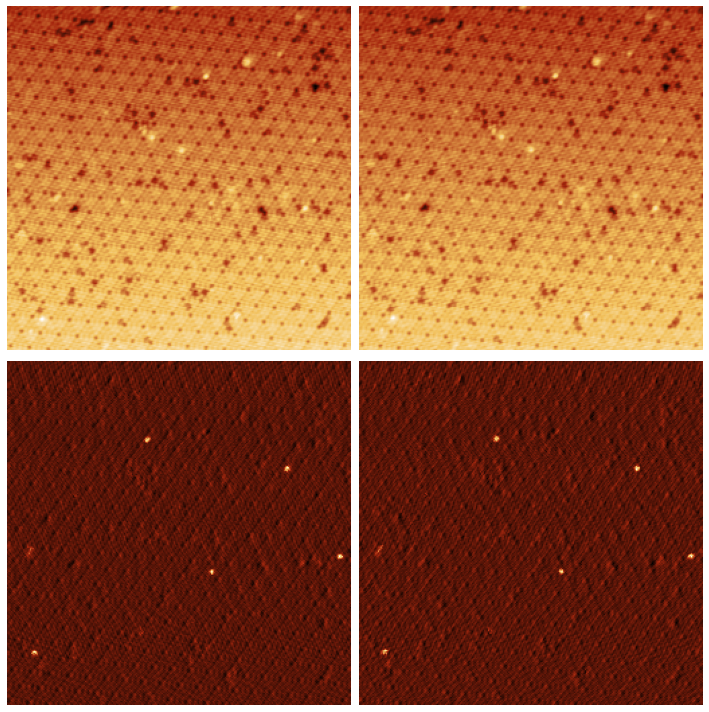

In [4]:
# read body
with open(file_path, 'rb') as f:
    read_all = f.read()
    offset = read_all.find('\x1A\x04'.encode(encoding = 'utf-8'))
    print('found start at {}'.format(offset))
    f.seek(offset + 2)
    data = np.fromfile(f, dtype = '>f')

data_shaped = data.reshape((2, 2, 256, 256))

for i in range(len(data_shaped)):
    for j in range(len(data_shaped[i])):
        if not j % 2 == 0:
            data_shaped[i][j] = np.fliplr(data_shaped[i][j])

'''
bindata = f.read(4 * 4 * 256 * 256)
data = np.zeros(256 * 256 * 4)
for j in range(len(data)):
    data[j] = struct.unpack('>f', bindata[j * 4: j * 4 + 4])[0]
data = data.reshape(2, 2, 256, 256)

#for i in range(4):
    #data[i] = np.rot90(data[i])
#print(data)
'''

# plot
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for i in range(len(data_shaped)):
    for j in range(len(data_shaped[i])):
        axes[i][j].imshow(data_shaped[i][j], cmap = gwyddion)
        axes[i][j].axis('off')
fig.tight_layout();


In [5]:
def header_reader(fname):
    '''
    Read the sxm file header into dictionary. Header entries
    as dict keys, and header contents as dict values.

    Parameters
    ----------------
    fname : .sxm file path.

    Return
    ----------------
    header : header dict file. 
    '''
    header_end = False # file_handler
    key = '' # Header_dict_key
    contents = '' # Header_data_buffer
    header = {} # Header_dict
    #Nanonis_header_regex = ':\w+([_>-]\w+[/ ]?\w+:)?'
    with open(fname, 'rb') as f:
        while not header_end:
            line = f.readline().decode(encoding = 'utf-8', errors = 'replace')
            if re.match(':SCANIT_END:\n', line):
                header_end = True
            elif re.match(':.+:',line):
                key = line[1:-2] # Read header_entry
                content = ''     # Clear 
            else:
                content += line
                header[key] = content.strip('\n')
    return header

In [6]:
info = header_reader(file_path)

info

In [8]:
# HEADER_CLASSIFICATION
trash_bin = ['NANONIS_VERSION',
             'SCANIT_TYPE',
             'REC_TEMP',
             'SCAN_PIXELS',
             'SCAN_TIME',
             'SCAN_RANGE',
             'SCAN_OFFSET',
             'SCAN_ANGLE',
             'Scan>channels'
            ]
table = ['Z-CONTROLLER',
        'DATA_INFO'
       ]
scan_info = ['REC_DATE',
             'REC_TIME',
             'ACQ_TIME',
             'SCAN_FILE',
             'SCAN_DIR',
             'COMMENT',
             'Scan>Scanfield',
             'Scan>pixels/line',
             'Scan>lines',
             'Scan>speed forw. (m/s)',
             'Scan>speed backw. (m/s)'
             ]

In [9]:
# Write DICT data into lists
data_info = info['DATA_INFO'].split('\n')
DATA_INFO = []
for row in data_info:
    DATA_INFO.append(row.strip('\t').split('\t'))
    
Z_Controller = info['Z-CONTROLLER'].split('\n')
Controller_config = []
for row in Z_Controller:
    Controller_config.append(row.strip('\t').split('\t'))

In [10]:
DATA_INFO

[['Channel', 'Name', 'Unit', 'Direction', 'Calibration', 'Offset'],
 ['14', 'Z', 'm', 'both', '1.291E-8', '0.000E+0'],
 ['0', 'Current', 'A', 'both', '1.000E-10', '0.000E+0']]

In [11]:
Controller_config

[['Name', 'on', 'Setpoint', 'P-gain', 'I-gain', 'T-const'],
 ['log Current',
  '1',
  '1.000E-10 A',
  '3.500E-12 m',
  '2.200E-7 m/s',
  '1.591E-5 s']]

In [12]:
# Z-CONTROLLER dict
key_list = DATA_INFO[0][1:]
channels = []
values = []
Channel_info = {}
for i in range(1, len(DATA_INFO)):
    channels.append(DATA_INFO[i][0])
    values.append(DATA_INFO[i][1:])
for i in range(len(channels)):
    chan_dict = {}
    for j in range(len(key_list)):
        chan_dict[key_list[j]] = values[i][j]
    Channel_info[channels[i]] = chan_dict
print(Channel_info)


{'14': {'Name': 'Z', 'Unit': 'm', 'Direction': 'both', 'Calibration': '1.291E-8', 'Offset': '0.000E+0'}, '0': {'Name': 'Current', 'Unit': 'A', 'Direction': 'both', 'Calibration': '1.000E-10', 'Offset': '0.000E+0'}}


In [13]:
# Regular Expression
'''
元字符：. ^ $ * + ? { } [ ] \ | ( )

--------字符--------
[] --- [a-c] or [abc]
元字符在[]中不特殊
^  --- ^c : 除了c以外的其它字符！必须置于匹配字符之前！
\  --- 移除元字符的特殊含义
\d --- [0-9]
\D --- [^0-9]
\s --- [ \t\n\r\f\v]
\S --- [^ \t\n\r\f\v]
\w --- [a-zA-Z0-9_]
\W --- [^a-zA-Z0-9_]
.  --- 除了换行符以外的任何字符

--------重复--------
*  --- 匹配*之前的字符0次到多次
+  --- 匹配+之前的字符一次或者多次
{} --- {m,n}最少重复m次，最多重复n次
?  --- 匹配0次或者1次
'''

'\n元字符：. ^ $ * + ? { } [ ] \\ | ( )\n\n--------字符--------\n[] --- [a-c] or [abc]\n元字符在[]中不特殊\n^  --- ^c : 除了c以外的其它字符！必须置于匹配字符之前！\n\\  --- 移除元字符的特殊含义\n\\d --- [0-9]\n\\D --- [^0-9]\n\\s --- [ \t\n\r\x0c\x0b]\n\\S --- [^ \t\n\r\x0c\x0b]\n\\w --- [a-zA-Z0-9_]\n\\W --- [^a-zA-Z0-9_]\n.  --- 除了换行符以外的任何字符\n\n--------重复--------\n*  --- 匹配*之前的字符0次到多次\n+  --- 匹配+之前的字符一次或者多次\n{} --- {m,n}最少重复m次，最多重复n次\n?  --- 匹配0次或者1次\n'

In [14]:
def data_type(dstr):
    '''
    to determine the type of data, and transform to proper fomation.
    
    Parameter
    --------------
    dstr : string read from file_header.

    Return
    --------------
    data : transformed data.
    '''

    scinot = '[+-]?\d+(?:\.\d+)[eE][+-]?\d{1,2}'
    digits = '[+-]?[0-9]*[.]{0,1}[0-9]+'
    #integer = '(\s\d+\s)'

    # Scientific notation?
    if re.search(scinot, dstr) != None: # if Scientific notation ?
        return re.findall(scinot, dstr)
    elif re.search(digits, dstr) != None: # if digits?
        return re.findall(digits, dstr)
    else:
        return dstr

In [15]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
thisdict.pop("model")
print(thisdict)

{'brand': 'Ford', 'year': 1964}
